# Library Imports

In [31]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc import math as pm_math
from scipy.stats import halfnorm, skewnorm
import pickle

# Model Specification

# Model Specification
## Simulated Data
$$ X \sim N(1,1) $$
$$ U \sim HN(0, \sigma_u^2) $$
$$ Y \sim SN(\xi, \sigma_v^2, \lambda)$$
$$ \xi = \alpha + \beta X - U $$
$$ \alpha = 5, \beta = 2 $$
## Priors
$$ \alpha \sim N(\mu_\alpha, \sigma_\alpha^2) $$
$$ \beta \sim N(\mu_\beta, \sigma_\beta^2) $$
$$ \sigma_v^2 \sim IG(\alpha_v, \beta_v) $$
$$ \sigma_u^2 \sim IG(\alpha_u, \beta_u) $$
$$ \lambda \sim TN(\mu_\lambda, \sigma_\lambda^2; a, b)$$


# Simulate Data: $$ \lambda = -0.5 $$

# Trace container: Skew

In [2]:
trace_skew = []

# Trace container: Normal

In [3]:
trace_norm = []

# List of sample sizes

In [4]:
sample_size = [50, 100, 200, 500]

# Model Generation: Skew Normal

In [5]:
def skew_norm(sample_size):
    np.random.seed(123)

    # Parameters
    n = sample_size
    alpha = 5
    beta = 2
    sigma_u = 1
    sigma_v = 1.5
    lambda_skew = -0.5

    # Simulate input X
    X = np.random.normal(1, 1, n)

    # Inefficiency term U ~ HalfNormal(0, sigma_u)
    U = halfnorm(scale=sigma_u).rvs(n)

    # Location ξ = α + βX − U
    xi = alpha + beta * X - U

    # Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
    Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

    # Put in DataFrame for convenience
    data = pd.DataFrame({'X': X, 'Y': Y})

    # Generate Model
    with pm.Model() as model:
        # Priors for parameters
        alpha_ = pm.Normal('alpha', mu=5, sigma=5)
        beta_ = pm.Normal('beta', mu=2, sigma=2)
        sigma_u = pm.InverseGamma('sigma_u', alpha=4, beta=3)
        sigma_v = pm.InverseGamma('sigma_v', alpha=2, beta=3)
        lam = pm.TruncatedNormal('lam', mu=-0.5, sigma=1, lower=-4, upper=0)

        # Latent inefficiency U ~ HalfNormal(0, sigma_u)
        U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

        # Linear predictor with inefficiency
        mu = alpha_ + beta_ * data['X'] - U

        # Skew-Normal likelihood
        Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

        # MCMC Sampling
        trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True, compute_covergence_checks=True, idata_kwargs={"log_likelihood": True})
        return model, trace

# Model Generation: Normal

In [6]:
def norm(sample_size):
    np.random.seed(123)

    # Parameters
    n = sample_size
    alpha = 5
    beta = 2
    sigma_u = 1
    sigma_v = 1.5
    lambda_skew = -0.5

    # Simulate input X
    X = np.random.normal(1, 1, n)

    # Inefficiency term U ~ HalfNormal(0, sigma_u)
    U = halfnorm(scale=sigma_u).rvs(n)

    # Location ξ = α + βX − U
    xi = alpha + beta * X - U

    # Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
    Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

    # Put in DataFrame for convenience
    data = pd.DataFrame({'X': X, 'Y': Y})

    # Generate Model
    with pm.Model() as model:
        # Priors for parameters
        alpha_ = pm.Normal('alpha', mu=5, sigma=5)
        beta_ = pm.Normal('beta', mu=2, sigma=2)
        sigma_u = pm.InverseGamma('sigma_u', alpha=4, beta=3)
        sigma_v = pm.InverseGamma('sigma_v', alpha=2, beta=3)
        # lam = pm.TruncatedNormal('lam', mu=-0.5, sigma=1, lower=-4, upper=0)

        # Latent inefficiency U ~ HalfNormal(0, sigma_u)
        U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

        # Linear predictor with inefficiency
        mu = alpha_ + beta_ * data['X'] - U

        # Normal likelihood
        Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma_v, observed=data['Y'])

        # MCMC Sampling
        trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True, compute_covergence_checks=True, idata_kwargs={"log_likelihood": True})
        return model, trace

# Trace Generation: Skew / Normal

In [7]:
sample_size = [50,100,200,500]
for size in sample_size:
    trace_norm.append(norm(size))
    trace_skew.append(skew_norm(size))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 21 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 27 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 37 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 78 seconds.


# Posterior Summaries: Skew

In [ ]:
import arviz as az
az.summary(trace_skew, round_to = 2)

Trace Skew 1


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.36  0.55    3.30     5.34       0.01     0.00   5974.30  11135.83   
beta     2.32  0.18    1.96     2.66       0.00     0.00  23570.51  17477.60   
sigma_u  0.82  0.35    0.29     1.48       0.01     0.00   2472.82   5313.94   
sigma_v  1.63  0.27    1.16     2.16       0.00     0.00   9029.79  10974.24   
lam     -0.66  0.46   -1.46    -0.00       0.00     0.00  10521.17  10556.26   
U[0]     0.56  0.48    0.00     1.44       0.00     0.00   8804.34  10176.98   
U[1]     0.82  0.68    0.00     2.07       0.01     0.01   4592.71   8235.78   
U[2]     1.00  0.83    0.00     2.55       0.01     0.01   4451.86   8979.12   
U[3]     1.06  0.88    0.00     2.71       0.01     0.01   4162.26   8391.99   
U[4]     0.36  0.32    0.00     0.95       0.00     0.00  13200.08   8400.74   
U[5]     0.60  0.52    0.00     1.55       0.01     0.01   7944.92   9436.90   
U[6]     0.43  0.38    0.00     1.12       0.00     0.00  11754.49   9716.28   
U[7]     0.69  0.58    0.00     1.76       0.01     0.01   5801.20   9393.07   
U[8]     0.50  0.43    0.00     1.29       0.00     0.00  10520.47   9930.79   
U[9]     0.63  0.54    0.00     1.61       0.01     0.01   7356.28  10408.07   
U[10]    0.55  0.46    0.00     1.39       0.00     0.00   9560.18  10641.97   
U[11]    0.65  0.55    0.00     1.68       0.01     0.01   6589.97   9029.39   
U[12]    0.61  0.52    0.00     1.57       0.01     0.01   7311.98   9186.16   
U[13]    0.51  0.44    0.00     1.31       0.00     0.00  10581.11  11559.46   
U[14]    0.56  0.48    0.00     1.43       0.00     0.00   9182.80  10389.39   
U[15]    0.67  0.57    0.00     1.70       0.01     0.01   6578.06   8967.73   
U[16]    0.92  0.77    0.00     2.34       0.01     0.01   4751.43   8683.62   
U[17]    0.44  0.39    0.00     1.15       0.00     0.00  11951.19   8970.58   
U[18]    0.77  0.65    0.00     1.99       0.01     0.01   5833.87  10052.30   
U[19]    0.59  0.51    0.00     1.53       0.01     0.00   7977.12  10166.98   
U[20]    0.42  0.38    0.00     1.11       0.00     0.00  11963.94  10944.52   
U[21]    0.63  0.53    0.00     1.58       0.01     0.01   7497.88  10152.64   
U[22]    0.66  0.56    0.00     1.70       0.01     0.01   7322.50   9970.73   
U[23]    0.66  0.55    0.00     1.67       0.01     0.01   7060.87  11273.16   
U[24]    0.71  0.60    0.00     1.79       0.01     0.01   6658.32  10397.56   
U[25]    0.81  0.67    0.00     2.05       0.01     0.01   5002.81   8975.03   
U[26]    0.54  0.46    0.00     1.38       0.00     0.00   8157.24   8036.23   
U[27]    0.54  0.46    0.00     1.39       0.00     0.00   9695.27  11013.58   
U[28]    0.63  0.53    0.00     1.60       0.01     0.00   7862.12   9476.47   
U[29]    0.66  0.56    0.00     1.70       0.01     0.01   7215.38  10779.07   
U[30]    0.67  0.57    0.00     1.70       0.01     0.01   7256.90  10323.53   
U[31]    0.74  0.63    0.00     1.85       0.01     0.01   5948.34   8988.74   
U[32]    0.88  0.74    0.00     2.23       0.01     0.01   4694.02   9731.20   
U[33]    0.59  0.51    0.00     1.52       0.01     0.00   8567.54  11044.97   
U[34]    0.65  0.55    0.00     1.68       0.01     0.01   6413.98   9120.02   
U[35]    1.08  0.89    0.00     2.74       0.01     0.01   3860.83   7476.50   
U[36]    0.50  0.43    0.00     1.27       0.00     0.00   9613.71   9804.51   
U[37]    0.97  0.79    0.00     2.41       0.01     0.01   4535.07   8759.21   
U[38]    0.85  0.71    0.00     2.15       0.01     0.01   5001.37   8652.88   
U[39]    0.55  0.47    0.00     1.40       0.00     0.00   8162.10   8821.66   
U[40]    0.63  0.54    0.00     1.62       0.01     0.01   6742.12   8207.09   
U[41]    0.54  0.47    0.00     1.40       0.00     0.00   9315.48  10658.93   
U[42]    0.52  0.45    0.00     1.34       0.00     0.00   8993.71  10388.91   
U[43]    0.64  0.54    0.00     1.64       0.01     0.01   6714.78   9284.00   
U[44]    

Trace Skew 2


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.57  0.46    4.66     6.36       0.01     0.00   2021.13   6237.18   
beta     1.90  0.12    1.67     2.13       0.00     0.00  11858.26  15126.29   
sigma_u  0.89  0.38    0.30     1.61       0.02     0.01    648.30   1649.09   
sigma_v  1.47  0.26    1.01     1.98       0.01     0.00   1812.63   2133.07   
lam     -0.90  0.59   -1.91    -0.00       0.01     0.00   7591.06   8374.65   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    1.40  1.10    0.00     3.50       0.04     0.02    946.31   2520.77   
U[96]    0.89  0.71    0.00     2.20       0.02     0.01   1632.01   3813.12   
U[97]    0.56  0.46    0.00     1.40       0.01     0.00   3975.73   7085.13   
U[98]    0.63  0.51    0.00     1.58       0.01     0.01   2753.50   7204.59   
U[99]    0.60  0.50    0.00     1.52       0.01     0.01   3327.13   6933.97   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.00  
lam       1.00  
...        ...  
U[95]     1.01  
U[96]     1.00  
U[97]     1.00  
U[98]     1.00  
U[99]     1.00  

[105 rows x 9 columns]

Trace Skew 3


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.24  0.44    4.39     6.06       0.01     0.00   1651.26   3468.74   
beta     2.07  0.10    1.89     2.26       0.00     0.00  16605.77  15884.98   
sigma_u  0.93  0.40    0.31     1.67       0.02     0.01    346.53    730.00   
sigma_v  1.66  0.27    1.16     2.15       0.01     0.00    729.84   1168.99   
lam     -1.02  0.55   -1.89    -0.00       0.01     0.00   4477.68   7288.26   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[195]   0.74  0.61    0.00     1.88       0.02     0.01   1330.59   3287.95   
U[196]   0.82  0.68    0.00     2.07       0.02     0.01   1087.26   2402.52   
U[197]   0.45  0.39    0.00     1.17       0.01     0.00   4470.94   9963.80   
U[198]   0.73  0.61    0.00     1.86       0.02     0.01   1406.73   3834.15   
U[199]   0.67  0.56    0.00     1.70       0.01     0.01   1742.99   4248.34   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.02  
sigma_v   1.01  
lam       1.00  
...        ...  
U[195]    1.00  
U[196]    1.01  
U[197]    1.00  
U[198]    1.01  
U[199]    1.00  

[205 rows x 9 columns]

Trace Skew 4


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.01  0.36    4.34     5.65       0.01     0.00   1681.88   4177.75   
beta     1.92  0.07    1.80     2.04       0.00     0.00  41440.53  17983.89   
sigma_u  0.75  0.27    0.30     1.26       0.01     0.01    392.96    975.20   
sigma_v  1.51  0.14    1.27     1.80       0.00     0.00   1268.15   1962.61   
lam     -0.52  0.33   -1.06    -0.00       0.00     0.00  10625.21  12222.39   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[495]   0.44  0.37    0.00     1.11       0.01     0.00   5016.47   9288.62   
U[496]   0.51  0.43    0.00     1.30       0.01     0.01   3870.08   7137.09   
U[497]   0.51  0.42    0.00     1.27       0.01     0.01   3414.89   8672.17   
U[498]   0.79  0.63    0.00     1.93       0.02     0.01   1259.72   3390.72   
U[499]   0.71  0.56    0.00     1.74       0.01     0.01   1681.05   4373.14   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.00  
lam       1.00  
...        ...  
U[495]    1.00  
U[496]    1.00  
U[497]    1.00  
U[498]    1.00  
U[499]    1.00  

[505 rows x 9 columns]

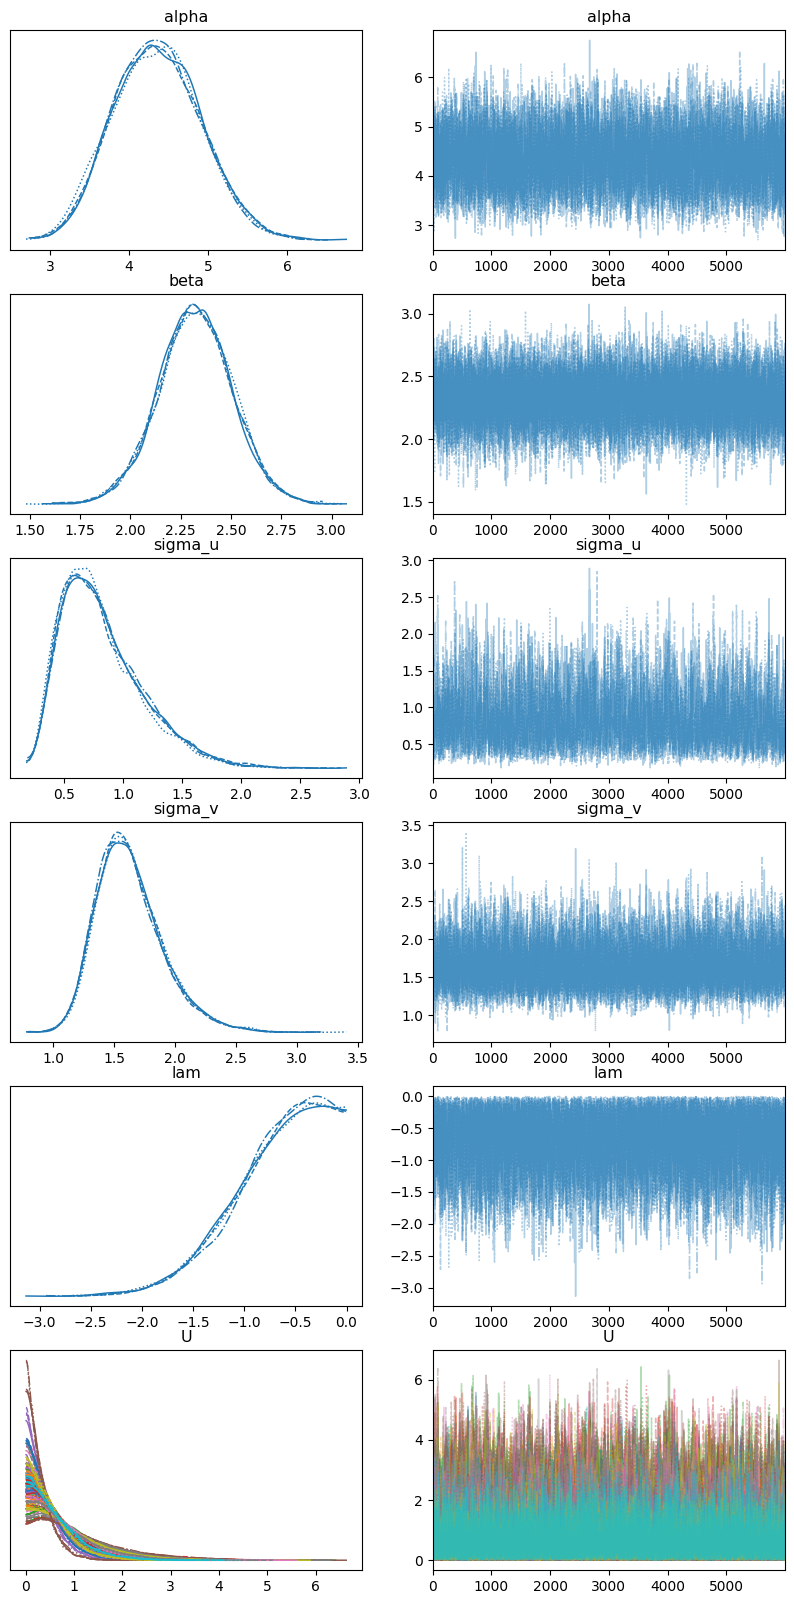

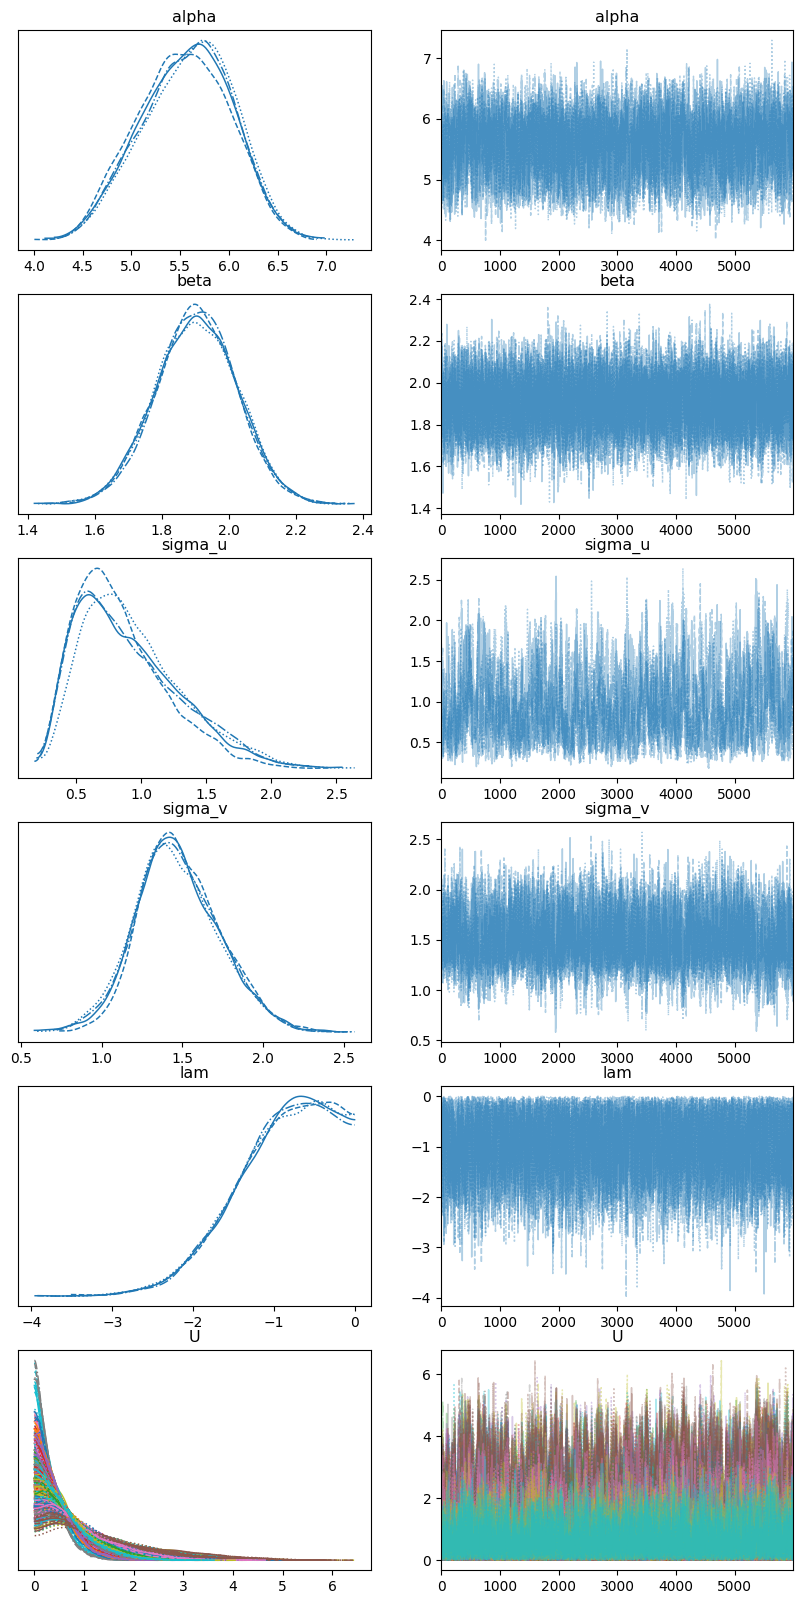

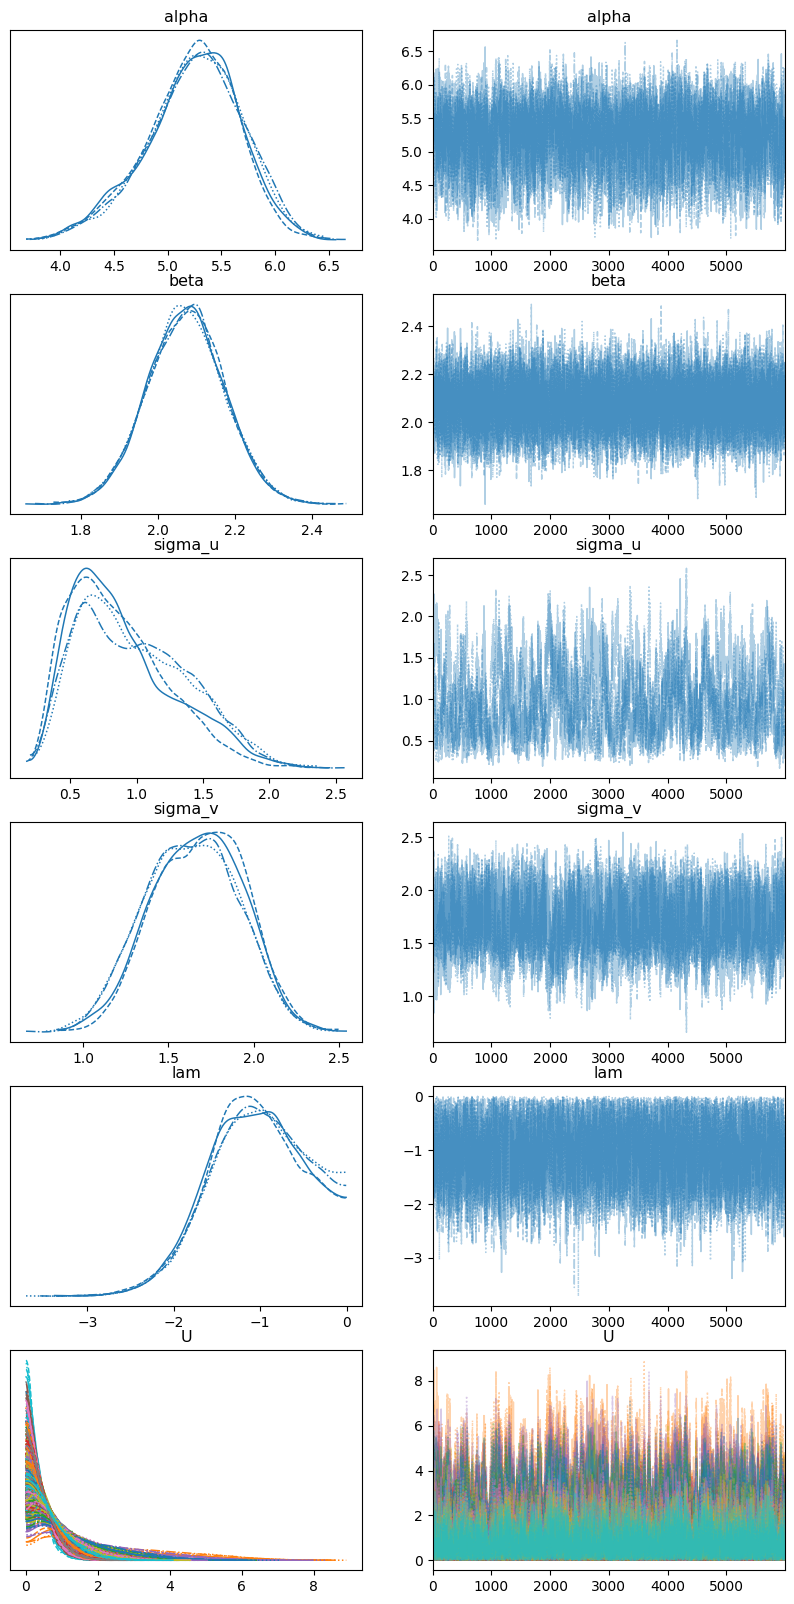

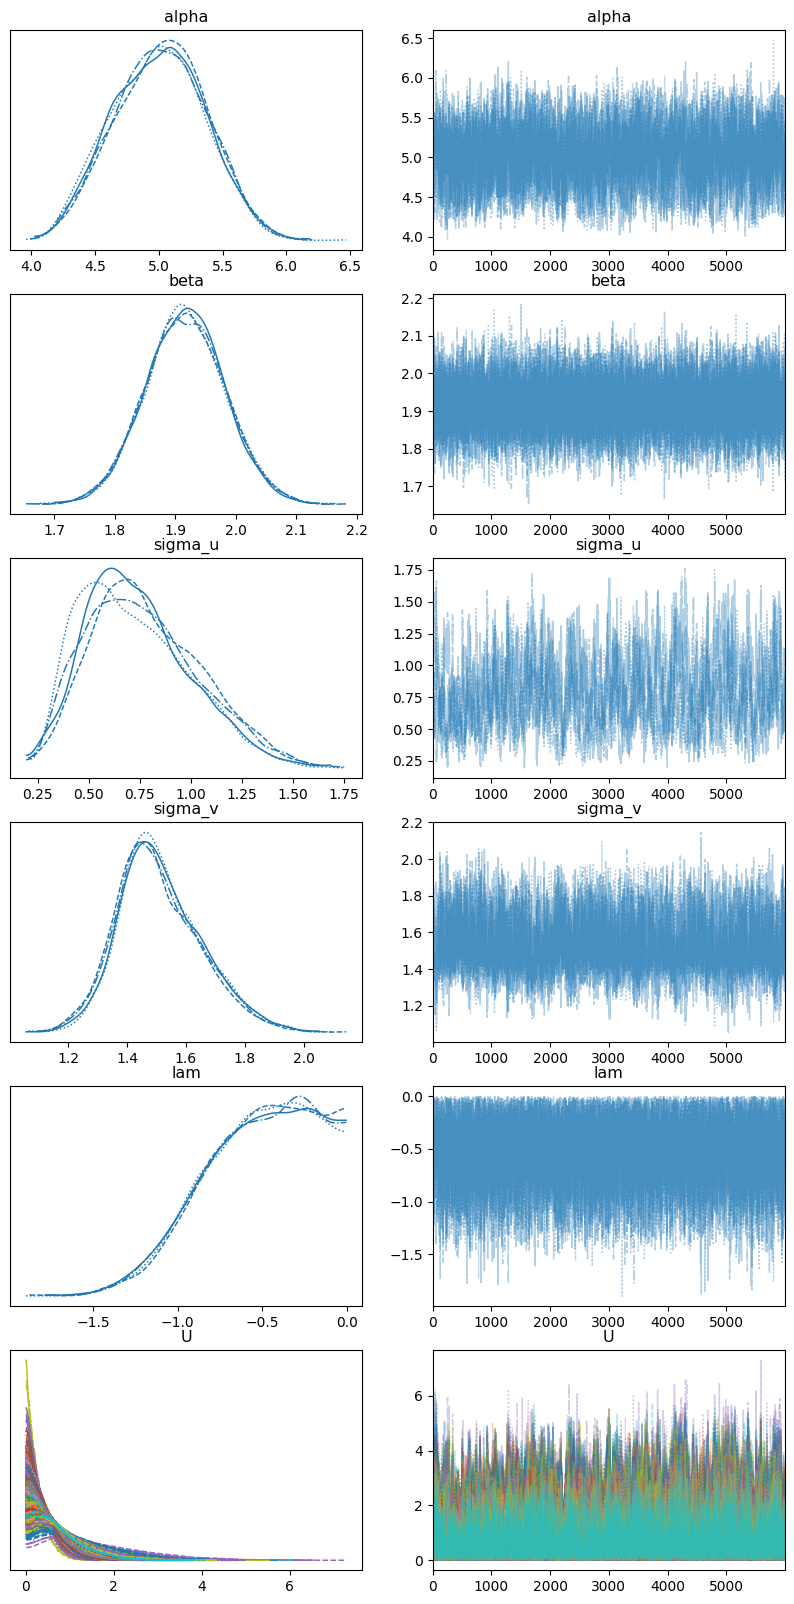

In [8]:
for i in range(4):  # Loop from 0 to 3
    print(f"Trace Skew {i + 1}")
    az.plot_trace(trace_skew[i][1], figsize=(10, 20))  # Use the second element (inference data)
    display(az.summary(trace_skew[i][1], round_to=2))  # Use the second element (inference data)

# Posterior Summaries: Normal

Trace Norm 1


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    3.71  0.40    2.97     4.48       0.01     0.00   3532.97   5175.00   
beta     2.33  0.18    1.98     2.66       0.00     0.00  22663.07  18818.48   
sigma_u  0.82  0.35    0.28     1.49       0.01     0.01   2369.98   4192.16   
sigma_v  1.44  0.18    1.11     1.78       0.00     0.00   8008.84   7652.04   
U[0]     0.56  0.48    0.00     1.43       0.01     0.00   8345.29  11256.49   
U[1]     0.82  0.69    0.00     2.12       0.01     0.01   4511.20   8477.24   
U[2]     1.03  0.84    0.00     2.59       0.01     0.01   3798.85   6664.13   
U[3]     1.09  0.89    0.00     2.75       0.02     0.01   3690.09   6920.89   
U[4]     0.37  0.33    0.00     0.97       0.00     0.00  14958.98  10770.83   
U[5]     0.59  0.50    0.00     1.50       0.01     0.01   7415.32  11308.12   
U[6]     0.43  0.38    0.00     1.13       0.00     0.00  11308.05  11073.01   
U[7]     0.69  0.58    0.00     1.77       0.01     0.01   5622.72   8577.25   
U[8]     0.49  0.43    0.00     1.27       0.00     0.00   8239.51   9368.61   
U[9]     0.62  0.53    0.00     1.59       0.01     0.01   7543.21  10203.27   
U[10]    0.54  0.47    0.00     1.39       0.00     0.00   7760.36   9209.42   
U[11]    0.65  0.55    0.00     1.66       0.01     0.01   6705.25   8883.76   
U[12]    0.61  0.52    0.00     1.54       0.01     0.01   6154.13   8839.19   
U[13]    0.51  0.44    0.00     1.30       0.00     0.00   8764.19  10152.66   
U[14]    0.56  0.48    0.00     1.45       0.01     0.00   7188.41   9290.26   
U[15]    0.67  0.57    0.00     1.71       0.01     0.01   6160.12  10716.84   
U[16]    0.93  0.77    0.00     2.36       0.01     0.01   4153.86   7933.32   
U[17]    0.44  0.39    0.00     1.16       0.00     0.00  10763.70  10095.73   
U[18]    0.77  0.65    0.00     1.95       0.01     0.01   5113.57   9247.11   
U[19]    0.59  0.51    0.00     1.52       0.01     0.00   7440.93   8312.15   
U[20]    0.43  0.38    0.00     1.12       0.00     0.00  11471.99   9977.55   
U[21]    0.61  0.52    0.00     1.57       0.01     0.01   7286.66  10732.67   
U[22]    0.66  0.56    0.00     1.68       0.01     0.01   5772.59   8888.14   
U[23]    0.65  0.55    0.00     1.65       0.01     0.01   6830.41  10026.19   
U[24]    0.71  0.60    0.00     1.81       0.01     0.01   5856.45   9803.11   
U[25]    0.81  0.67    0.00     2.04       0.01     0.01   4753.60   8279.37   
U[26]    0.54  0.47    0.00     1.39       0.00     0.00   8712.31  10586.37   
U[27]    0.54  0.46    0.00     1.38       0.00     0.00   8259.37   8783.80   
U[28]    0.62  0.53    0.00     1.60       0.01     0.01   6784.94   9480.17   
U[29]    0.65  0.56    0.00     1.66       0.01     0.01   6138.67   9538.70   
U[30]    0.66  0.57    0.00     1.71       0.01     0.01   5874.50  10014.31   
U[31]    0.74  0.63    0.00     1.90       0.01     0.01   5153.27   9245.50   
U[32]    0.90  0.74    0.00     2.26       0.01     0.01   4322.15   7886.88   
U[33]    0.58  0.49    0.00     1.48       0.01     0.01   7899.35  11233.63   
U[34]    0.65  0.56    0.00     1.67       0.01     0.01   6659.23  10115.75   
U[35]    1.12  0.91    0.00     2.81       0.02     0.01   3482.06   6279.11   
U[36]    0.49  0.43    0.00     1.29       0.00     0.00   9905.45   9520.67   
U[37]    0.98  0.81    0.00     2.47       0.01     0.01   4045.60   7711.69   
U[38]    0.86  0.71    0.00     2.17       0.01     0.01   4468.03   7966.88   
U[39]    0.56  0.48    0.00     1.43       0.01     0.01   7631.02   9810.76   
U[40]    0.63  0.54    0.00     1.62       0.01     0.01   6299.43   9319.95   
U[41]    0.54  0.47    0.00     1.40       0.00     0.00   8590.44   9760.16   
U[42]    0.52  0.45    0.00     1.34       0.00     0.00   9158.74  10693.24   
U[43]    0.64  0.54    0.00     1.62       0.01     0.01   6881.32   9499.38   
U[44]    0.51  0.44    0.00     1.32       0.00     0.00   8839.16  10483.70   
U[45]    

Trace Norm 2


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.89  0.33    4.28     5.52       0.01     0.00    827.18   1894.72   
beta     1.88  0.12    1.65     2.11       0.00     0.00  11243.10  15840.32   
sigma_u  0.91  0.38    0.29     1.62       0.01     0.01    642.45   1636.12   
sigma_v  1.24  0.15    0.94     1.52       0.00     0.00   1133.53   1561.78   
U[0]     0.57  0.47    0.00     1.42       0.01     0.00   4583.54   8271.12   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    1.48  1.09    0.00     3.50       0.04     0.02    925.74   2545.30   
U[96]    0.90  0.71    0.00     2.20       0.02     0.01   1590.77   4096.76   
U[97]    0.56  0.47    0.00     1.42       0.01     0.00   4383.46   9734.62   
U[98]    0.63  0.52    0.00     1.59       0.01     0.01   3227.61   8342.59   
U[99]    0.60  0.49    0.00     1.49       0.01     0.01   3273.31   7109.22   

         r_hat  
alpha     1.01  
beta      1.00  
sigma_u   1.01  
sigma_v   1.00  
U[0]      1.00  
...        ...  
U[95]     1.00  
U[96]     1.00  
U[97]     1.00  
U[98]     1.00  
U[99]     1.00  

[104 rows x 9 columns]

Trace Norm 3


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.52  0.36    3.88     5.18       0.02     0.01    291.92   1103.26   
beta     2.07  0.10    1.88     2.26       0.00     0.00  16237.17  16027.28   
sigma_u  1.12  0.42    0.37     1.84       0.03     0.01    251.87    687.52   
sigma_v  1.30  0.15    1.01     1.57       0.01     0.00    371.29   1083.99   
U[0]     0.61  0.50    0.00     1.54       0.01     0.01   3005.35   8979.55   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[195]   0.88  0.67    0.00     2.09       0.02     0.01   1333.55   5890.88   
U[196]   0.98  0.73    0.00     2.31       0.02     0.01    954.76   4546.81   
U[197]   0.50  0.43    0.00     1.29       0.01     0.00   5862.06   9839.48   
U[198]   0.87  0.67    0.00     2.10       0.02     0.01   1214.47   5672.94   
U[199]   0.78  0.61    0.00     1.90       0.02     0.01   1453.45   7286.67   

         r_hat  
alpha     1.02  
beta      1.00  
sigma_u   1.03  
sigma_v   1.02  
U[0]      1.00  
...        ...  
U[195]    1.01  
U[196]    1.01  
U[197]    1.00  
U[198]    1.01  
U[199]    1.01  

[204 rows x 9 columns]

Trace Norm 4


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.50  0.24    4.08     4.95       0.01     0.00    468.90   1164.47   
beta     1.92  0.07    1.79     2.04       0.00     0.00  30572.20  16429.39   
sigma_u  0.77  0.28    0.30     1.28       0.01     0.01    406.49   1003.21   
sigma_v  1.38  0.08    1.24     1.53       0.00     0.00    702.50   1246.07   
U[0]     0.90  0.70    0.00     2.17       0.02     0.01   1062.84   3041.67   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[495]   0.44  0.38    0.00     1.13       0.01     0.00   4619.87   8551.28   
U[496]   0.52  0.43    0.00     1.31       0.01     0.01   3541.32   7044.24   
U[497]   0.51  0.43    0.00     1.29       0.01     0.01   3141.20   6532.05   
U[498]   0.82  0.64    0.00     1.98       0.02     0.01   1257.73   3360.18   
U[499]   0.72  0.58    0.00     1.78       0.01     0.01   1644.36   3658.60   

         r_hat  
alpha     1.02  
beta      1.00  
sigma_u   1.02  
sigma_v   1.01  
U[0]      1.01  
...        ...  
U[495]    1.00  
U[496]    1.00  
U[497]    1.00  
U[498]    1.01  
U[499]    1.00  

[504 rows x 9 columns]

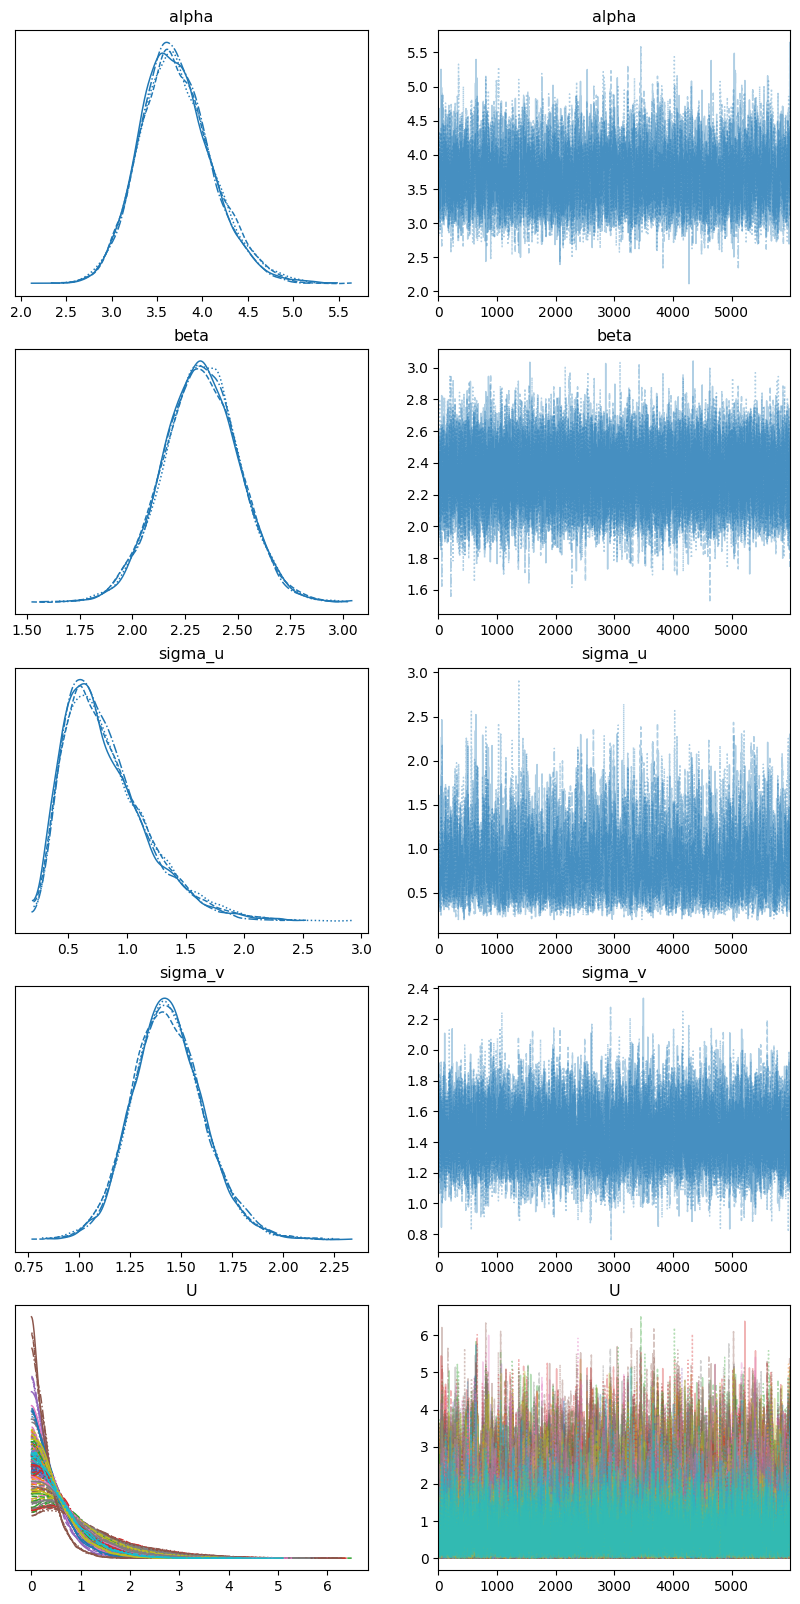

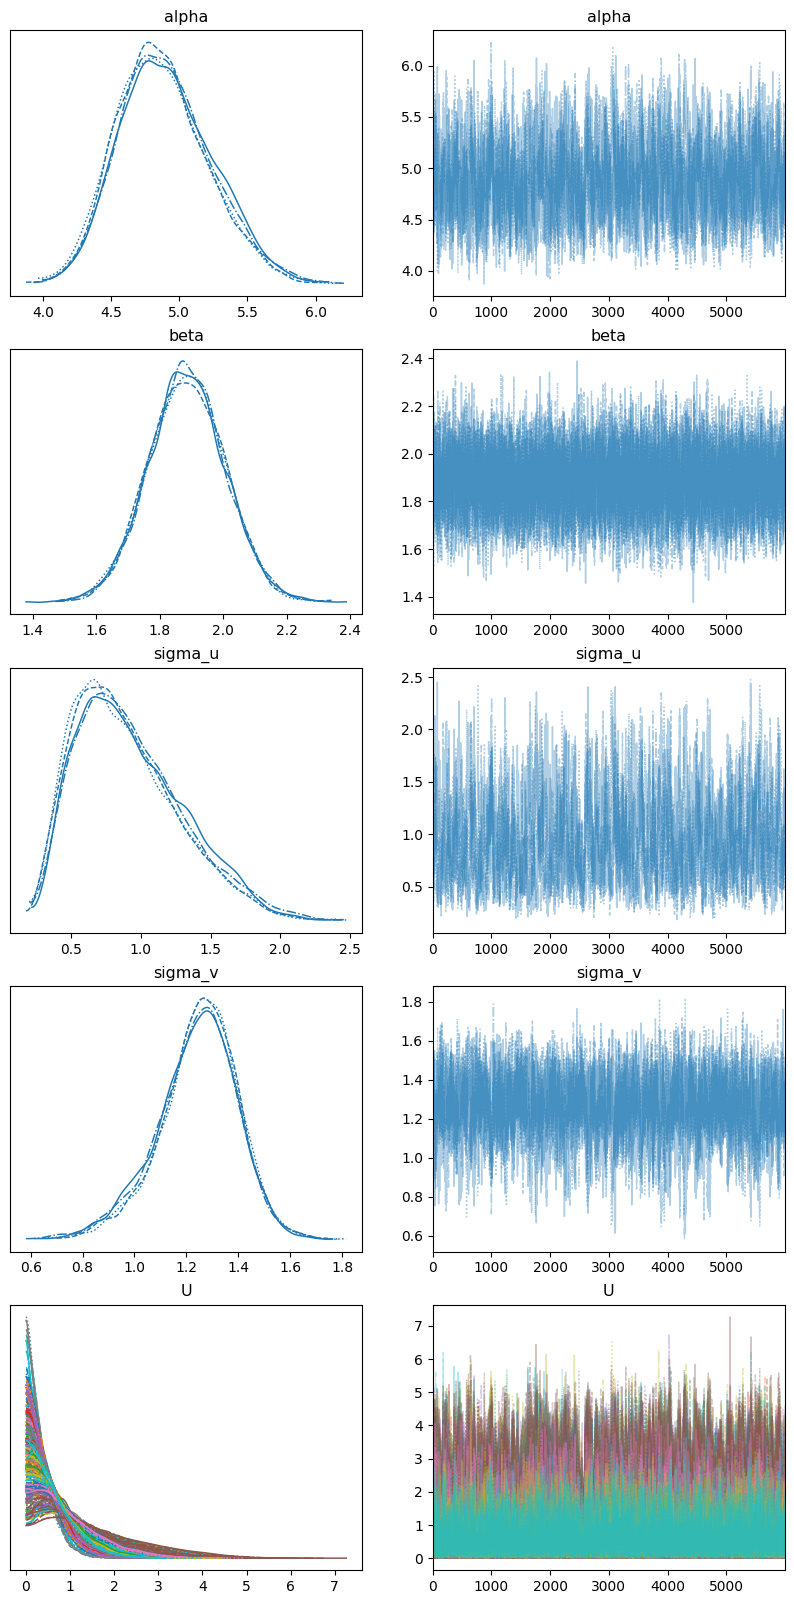

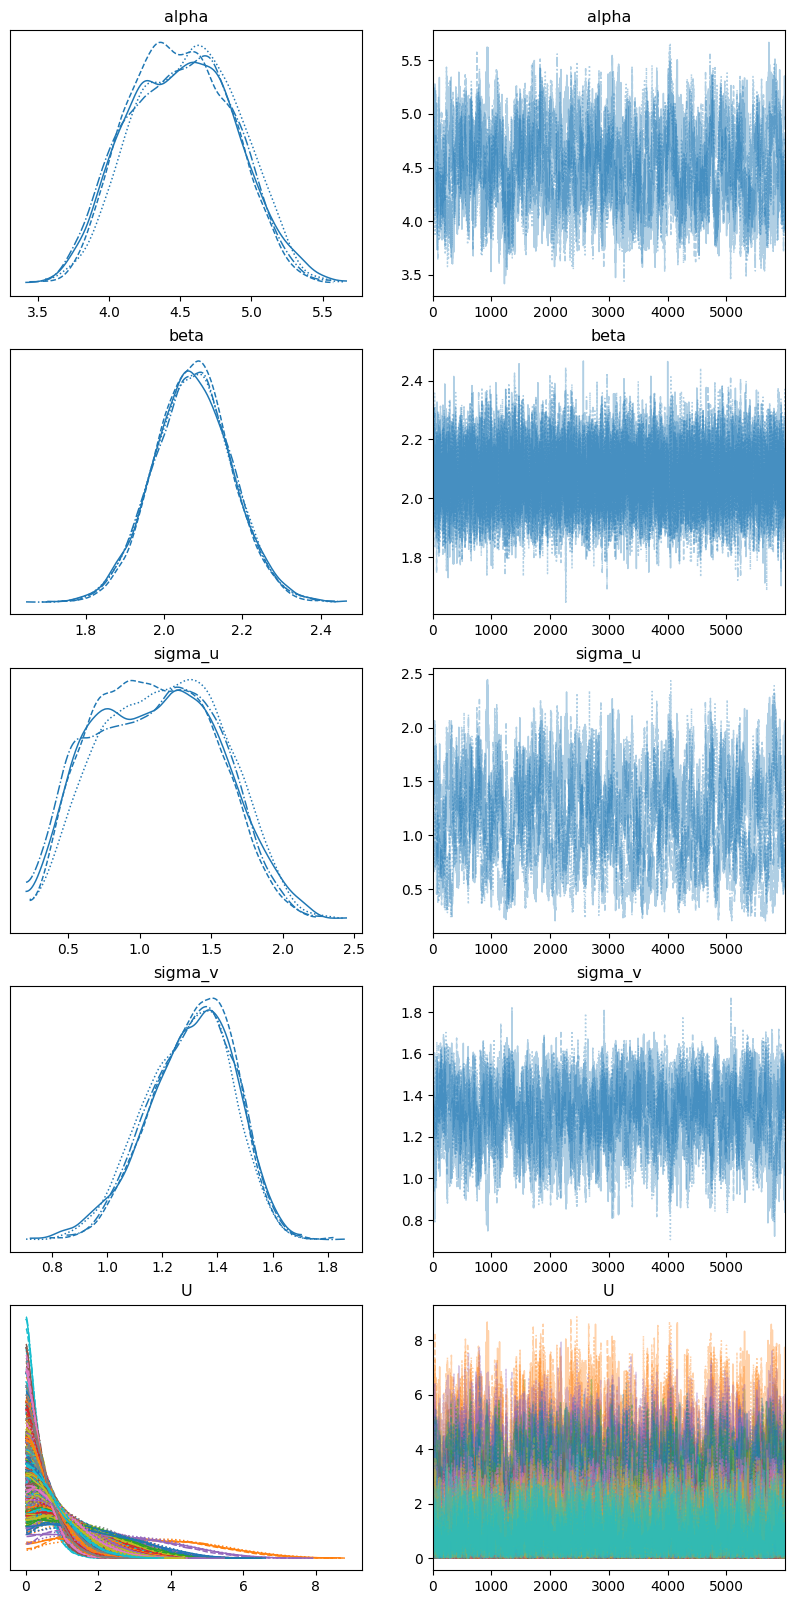

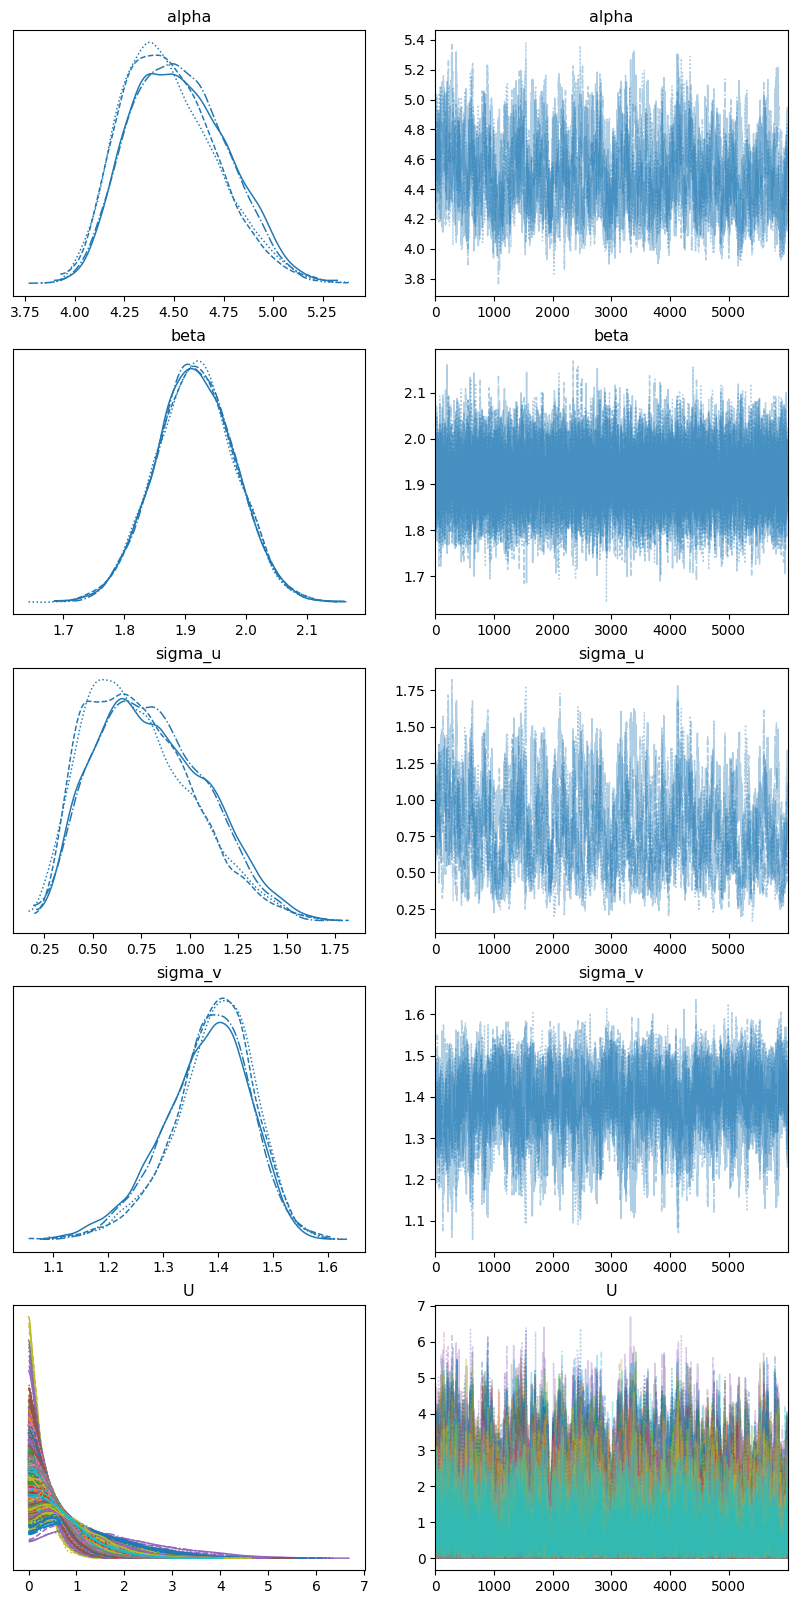

In [9]:
for i in range(4):  # Loop from 0 to 3
    print(f"Trace Norm {i + 1}")
    az.plot_trace(trace_norm[i][1], figsize=(10, 20))  # Use the second element (InferenceData)
    display(az.summary(trace_norm[i][1], round_to=2))  # Use the second element (InferenceData)

# Model Comparison

## Leave-One-Out (LOO)

In [10]:
for i in range(len(trace_skew)):  # Loop through the indices of trace_skew and trace_norm
    print(f"Comparison for sample size {sample_size[i]}:")
    df_comp_loo = az.compare({"Skew Normal": trace_skew[i][1], "Normal": trace_norm[i][1]})
    display(df_comp_loo)

Comparison for sample size 50:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank   elpd_loo     p_loo  elpd_diff        weight        se  \
Normal          0 -93.773418  8.727217   0.000000  1.000000e+00  6.883099   
Skew Normal     1 -94.056246  8.635845   0.282829  3.330669e-16  7.092165   

                 dse  warning scale  
Normal       0.00000     True   log  
Skew Normal  0.30187     True   log

Comparison for sample size 100:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importan

rank    elpd_loo      p_loo  elpd_diff  weight        se  \
Normal          0 -174.664244  20.414813   0.000000     1.0  6.538567   
Skew Normal     1 -174.768821  20.239133   0.104578     0.0  6.636892   

                  dse  warning scale  
Normal       0.000000     True   log  
Skew Normal  0.375536     True   log

Comparison for sample size 200:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/s

rank    elpd_loo      p_loo  elpd_diff  weight         se  \
Normal          0 -364.831782  48.936856   0.000000     1.0  11.819404   
Skew Normal     1 -365.066495  37.178491   0.234713     0.0  11.654663   

                 dse  warning scale  
Normal       0.00000     True   log  
Skew Normal  0.59063     True   log

Comparison for sample size 500:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    elpd_loo      p_loo  elpd_diff  weight         se  \
Normal          0 -903.198703  58.577804   0.000000     1.0  17.776195   
Skew Normal     1 -903.601085  55.649241   0.402382     0.0  17.832995   

                  dse  warning scale  
Normal       0.000000    False   log  
Skew Normal  0.557027     True   log

## RMSE Parameter Estimates

In [11]:
true_vals_skew = np.array([5, 2, 1.5, 1, -0.5])
true_vals_norm = np.array([5, 2, 1.5, 1])
n_values = [50, 100, 200, 500]

for i in range(4):  # 0~3
    skew_summary = az.summary(trace_skew[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u", "lam"])
    norm_summary = az.summary(trace_norm[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u"])

    skew_means = skew_summary["mean"].values
    norm_means = norm_summary["mean"].values

    rmse_skew = np.sqrt((skew_means - true_vals_skew)**2)
    rmse_norm = np.sqrt((norm_means - true_vals_norm)**2)

    df = pd.DataFrame({
        "Parameter": ["alpha", "beta", "sigma_v", "sigma_u", "lambda"],
        "Skew Model RMSE": list(rmse_skew),
        "Normal Model RMSE": list(rmse_norm) + [np.nan]
    })

    print(f"\n RMSE Parameter Estimates (n = {n_values[i]})")
    display(df)



 RMSE Parameter Estimates (n = 50)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.642              1.290
1      beta            0.324              0.326
2   sigma_v            0.127              0.064
3   sigma_u            0.183              0.182
4    lambda            0.156                NaN


 RMSE Parameter Estimates (n = 100)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.568              0.113
1      beta            0.098              0.116
2   sigma_v            0.026              0.257
3   sigma_u            0.105              0.090
4    lambda            0.396                NaN


 RMSE Parameter Estimates (n = 200)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.239              0.485
1      beta            0.074              0.073
2   sigma_v            0.157              0.196
3   sigma_u            0.069              0.124
4    lambda            0.519                NaN


 RMSE Parameter Estimates (n = 500)


Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.007              0.501
1      beta            0.084              0.084
2   sigma_v            0.012              0.116
3   sigma_u            0.246              0.228
4    lambda            0.016                NaN

## RMSE Y_OBS

In [21]:
rmse_skew_list = []
rmse_norm_list = []

for i in range(4):  # corresponds to n=50, 100, 200, 500
    # Skew model
    with trace_skew[i][0]:
        ppc_skew = pm.sample_posterior_predictive(trace_skew[i][1], var_names=["Y_obs"])
    y_pred_skew = ppc_skew.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_skew = trace_skew[i][1].observed_data['Y_obs'].values
    rmse_skew = np.sqrt(np.mean((y_obs_skew - y_pred_skew) ** 2))
    rmse_skew_list.append(rmse_skew)

    # Normal model
    with trace_norm[i][0]:
        ppc_norm = pm.sample_posterior_predictive(trace_norm[i][1], var_names=["Y_obs"])
    y_pred_norm = ppc_norm.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_norm = trace_norm[i][1].observed_data['Y_obs'].values
    rmse_norm = np.sqrt(np.mean((y_obs_norm - y_pred_norm) ** 2))
    rmse_norm_list.append(rmse_norm)


for idx, n_val in enumerate([50, 100, 200, 500]):
    print(f"n = {n_val} → RMSE_Skew: {rmse_skew_list[idx]:.4f}, RMSE_Norm: {rmse_norm_list[idx]:.4f}")

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

n = 50 → RMSE_Skew: 1.3018, RMSE_Norm: 1.2976
n = 100 → RMSE_Skew: 1.1045, RMSE_Norm: 1.0938
n = 200 → RMSE_Skew: 1.2347, RMSE_Norm: 1.1300
n = 500 → RMSE_Skew: 1.3141, RMSE_Norm: 1.3065


## RMSE Ineffiency

In [13]:
import pandas as pd
from scipy.stats import halfnorm

rmse_u_skew_list = []
rmse_u_norm_list = []
n_values = [50, 100, 200, 500]

for i, n in enumerate(n_values):
    np.random.seed(123)
    U_true = halfnorm(scale=1).rvs(n)

    # Skew
    U_est_skew = trace_skew[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_skew = np.sqrt(np.mean((U_true - U_est_skew)**2))
    rmse_u_skew_list.append(rmse_u_skew)

    # Norm
    U_est_norm = trace_norm[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_norm = np.sqrt(np.mean((U_true - U_est_norm)**2))
    rmse_u_norm_list.append(rmse_u_norm)

# Make DataFrame
df_u_rmse = pd.DataFrame({
    "Sample Size (n)": n_values,
    "Skew Model RMSE (U)": rmse_u_skew_list,
    "Normal Model RMSE (U)": rmse_u_norm_list
})

display(df_u_rmse)


Sample Size (n)  Skew Model RMSE (U)  Normal Model RMSE (U)
0               50             0.766473               0.768016
1              100             0.727861               0.728612
2              200             0.682864               0.724931
3              500             0.659412               0.657942

# Metrics Containers

In [56]:
# Metrics Containers
skew_container = {}
norm_container = {}

# Skew Summary Containers
skew_container[50] = az.summary(trace_skew[0][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
skew_container[100] = az.summary(trace_skew[1][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
skew_container[200] = az.summary(trace_skew[2][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
skew_container[500] = az.summary(trace_skew[3][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]

# Normal Summary Containers
norm_container[50] = az.summary(trace_norm[0][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
norm_container[100] = az.summary(trace_norm[1][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
norm_container[200] = az.summary(trace_norm[2][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]
norm_container[500] = az.summary(trace_norm[3][1])[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']]

# LOO Container
loo = {}
loo[50] = az.compare({"Skew Normal": trace_skew[0][1], "Normal": trace_norm[0][1]})
loo[100] = az.compare({"Skew Normal": trace_skew[1][1], "Normal": trace_norm[1][1]})
loo[200] = az.compare({"Skew Normal": trace_skew[2][1], "Normal": trace_norm[2][1]})
loo[500] = az.compare({"Skew Normal": trace_skew[3][1], "Normal": trace_norm[3][1]})

# RMSE Parameter Container
rmse_param = {}

true_vals_skew = np.array([5, 2, 1.5, 1, -0.5])
true_vals_norm = np.array([5, 2, 1.5, 1])
n_values = [50, 100, 200, 500]
for i in range(4):  # 0~3
    skew_summary = az.summary(trace_skew[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u", "lam"])
    norm_summary = az.summary(trace_norm[i][1], var_names=["alpha", "beta", "sigma_v", "sigma_u"])

    skew_means = skew_summary["mean"].values
    norm_means = norm_summary["mean"].values

    rmse_skew = np.sqrt((skew_means - true_vals_skew)**2)
    rmse_norm = np.sqrt((norm_means - true_vals_norm)**2)

    df = pd.DataFrame({
        "Parameter": ["alpha", "beta", "sigma_v", "sigma_u", "lambda"],
        "Skew Model RMSE": list(rmse_skew),
        "Normal Model RMSE": list(rmse_norm) + [np.nan]
    })
    rmse_param[n_values[i]] = df

# RMSE Y_Obs Container
rmse_skew_list = []
rmse_norm_list = []

for i in range(4):  # corresponds to n=50, 100, 200, 500
    # Skew model
    with trace_skew[i][0]:
        ppc_skew = pm.sample_posterior_predictive(trace_skew[i][1], var_names=["Y_obs"])
    y_pred_skew = ppc_skew.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_skew = trace_skew[i][1].observed_data['Y_obs'].values
    rmse_skew = np.sqrt(np.mean((y_obs_skew - y_pred_skew) ** 2))
    rmse_skew_list.append(rmse_skew)

    # Normal model
    with trace_norm[i][0]:
        ppc_norm = pm.sample_posterior_predictive(trace_norm[i][1], var_names=["Y_obs"])
    y_pred_norm = ppc_norm.posterior_predictive['Y_obs'].mean(dim=["chain", "draw"]).values
    y_obs_norm = trace_norm[i][1].observed_data['Y_obs'].values
    rmse_norm = np.sqrt(np.mean((y_obs_norm - y_pred_norm) ** 2))
    rmse_norm_list.append(rmse_norm)

pred_container = pd.DataFrame({
    'n': [50, 100, 200, 500],
    'Skew Model RMSE': rmse_skew_list,
    'Normal Model RMSE': rmse_norm_list    
})

# RMSE Ineffiency Container
rmse_u_skew_list = []
rmse_u_norm_list = []
n_values = [50, 100, 200, 500]

for i, n in enumerate(n_values):
    np.random.seed(123)
    U_true = halfnorm(scale=1).rvs(n)

    # Skew
    U_est_skew = trace_skew[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_skew = np.sqrt(np.mean((U_true - U_est_skew)**2))
    rmse_u_skew_list.append(rmse_u_skew)

    # Norm
    U_est_norm = trace_norm[i][1].posterior["U"].mean(dim=["chain", "draw"]).values
    rmse_u_norm = np.sqrt(np.mean((U_true - U_est_norm)**2))
    rmse_u_norm_list.append(rmse_u_norm)

# Make DataFrame
inefficiency_container = pd.DataFrame({
    "Sample Size (n)": n_values,
    "Skew Model RMSE (U)": rmse_u_skew_list,
    "Normal Model RMSE (U)": rmse_u_norm_list
})


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Libra

Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

Sampling: [Y_obs]


Output()

In [41]:
data = {
    'dict': skew_container
}

lam=-0.5

In [42]:
with open('skew.pkl', 'wb') as f:
    pickle.dump(skew_container, f)

In [45]:
with open('skew.pkl', 'rb') as f:
    skew_container = pickle.load(f)

skew_container

{50:           mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
 alpha    4.366  0.550   3.358    5.404    5465.0   10265.0    1.0
 beta     2.325  0.186   1.993    2.690   23718.0   17303.0    1.0
 sigma_u  0.815  0.352   0.267    1.477    2414.0    4585.0    1.0
 sigma_v  1.629  0.275   1.148    2.162    8645.0    9657.0    1.0
 lam     -0.663  0.456  -1.455   -0.000   10329.0   10462.0    1.0
 U[0]     0.561  0.481   0.000    1.427    7931.0    9811.0    1.0
 U[1]     0.821  0.687   0.000    2.099    5347.0    8836.0    1.0
 U[2]     1.000  0.834   0.000    2.554    3864.0    7503.0    1.0
 U[3]     1.055  0.870   0.000    2.697    3772.0    6725.0    1.0
 U[4]     0.362  0.328   0.000    0.955   12974.0    9151.0    1.0
 U[5]     0.600  0.519   0.000    1.544    7371.0    9921.0    1.0
 U[6]     0.424  0.376   0.000    1.112   12913.0   10654.0    1.0
 U[7]     0.696  0.590   0.000    1.787    5818.0    9428.0    1.0
 U[8]     0.494  0.427   0.000    1.268   11107.0   10869.

In [ ]:
skew_container[100].to_csv(f"{lam}skew_container.csv",index=True)

In [63]:
num = [50, 100, 200, 500]
lam = -0.5
for i in num:
    with open('inef.pkl', 'wb') as f:
        pickle.dump(inefficiency_container, f)
    with open('inef.pkl', 'rb') as f:
        inefficiency_container = pickle.load(f)
    inefficiency_container.to_csv(f"{lam}inefficiency.csv",index=True)

In [60]:
rmse_param[50]

Parameter  Skew Model RMSE  Normal Model RMSE
0     alpha            0.634              1.289
1      beta            0.325              0.329
2   sigma_v            0.129              0.065
3   sigma_u            0.185              0.177
4    lambda            0.163                NaN

In [64]:
inefficiency_container

Sample Size (n)  Skew Model RMSE (U)  Normal Model RMSE (U)
0               50             0.767067               0.765714
1              100             0.728365               0.729409
2              200             0.682970               0.730455
3              500             0.660556               0.658993

In [ ]:
plot_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

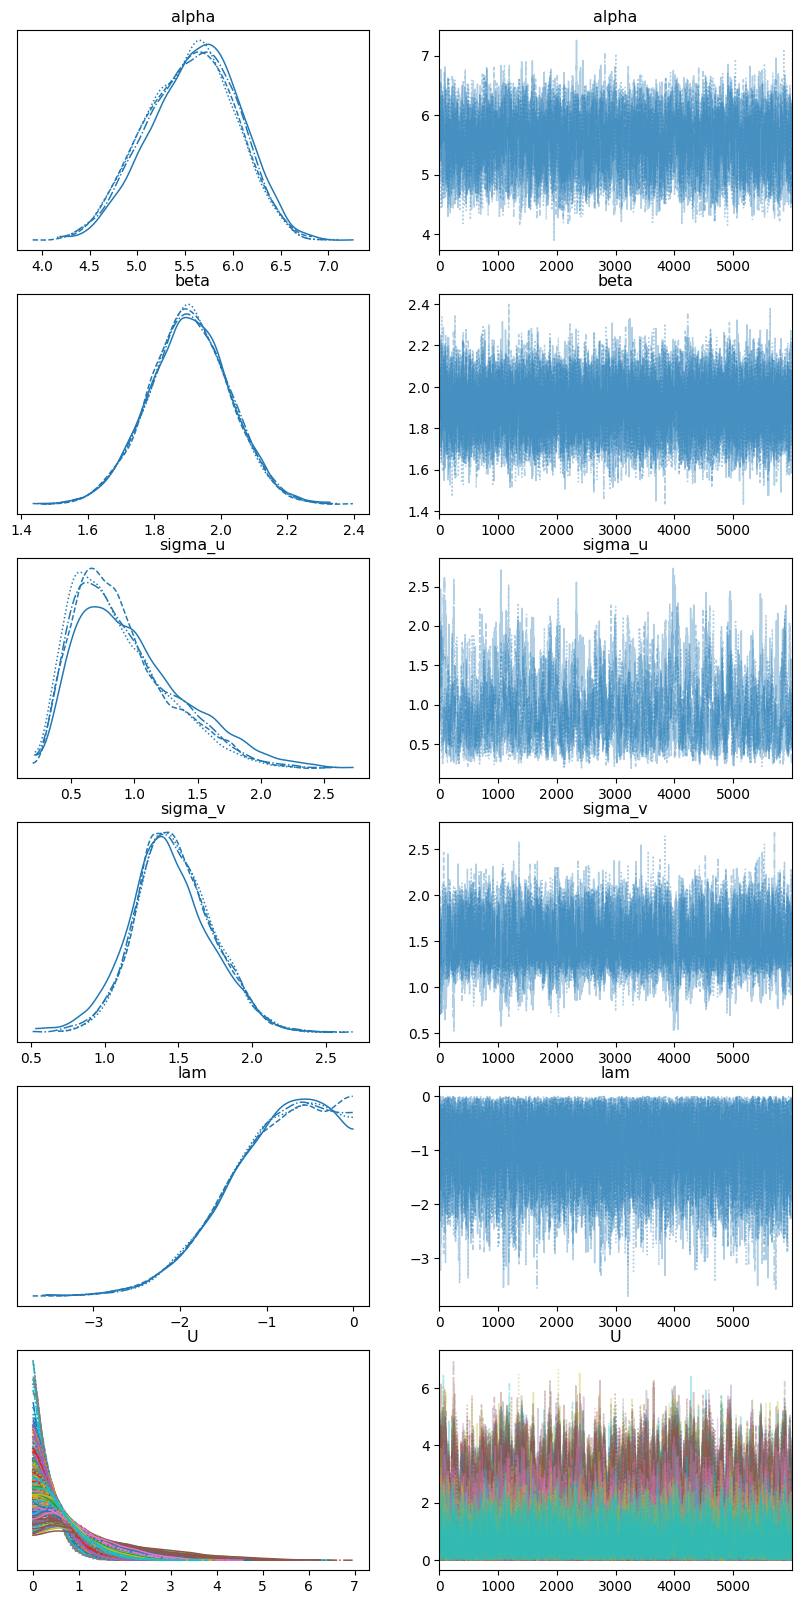

In [68]:
az.plot_trace(trace_skew[1][1], figsize=(10, 20));

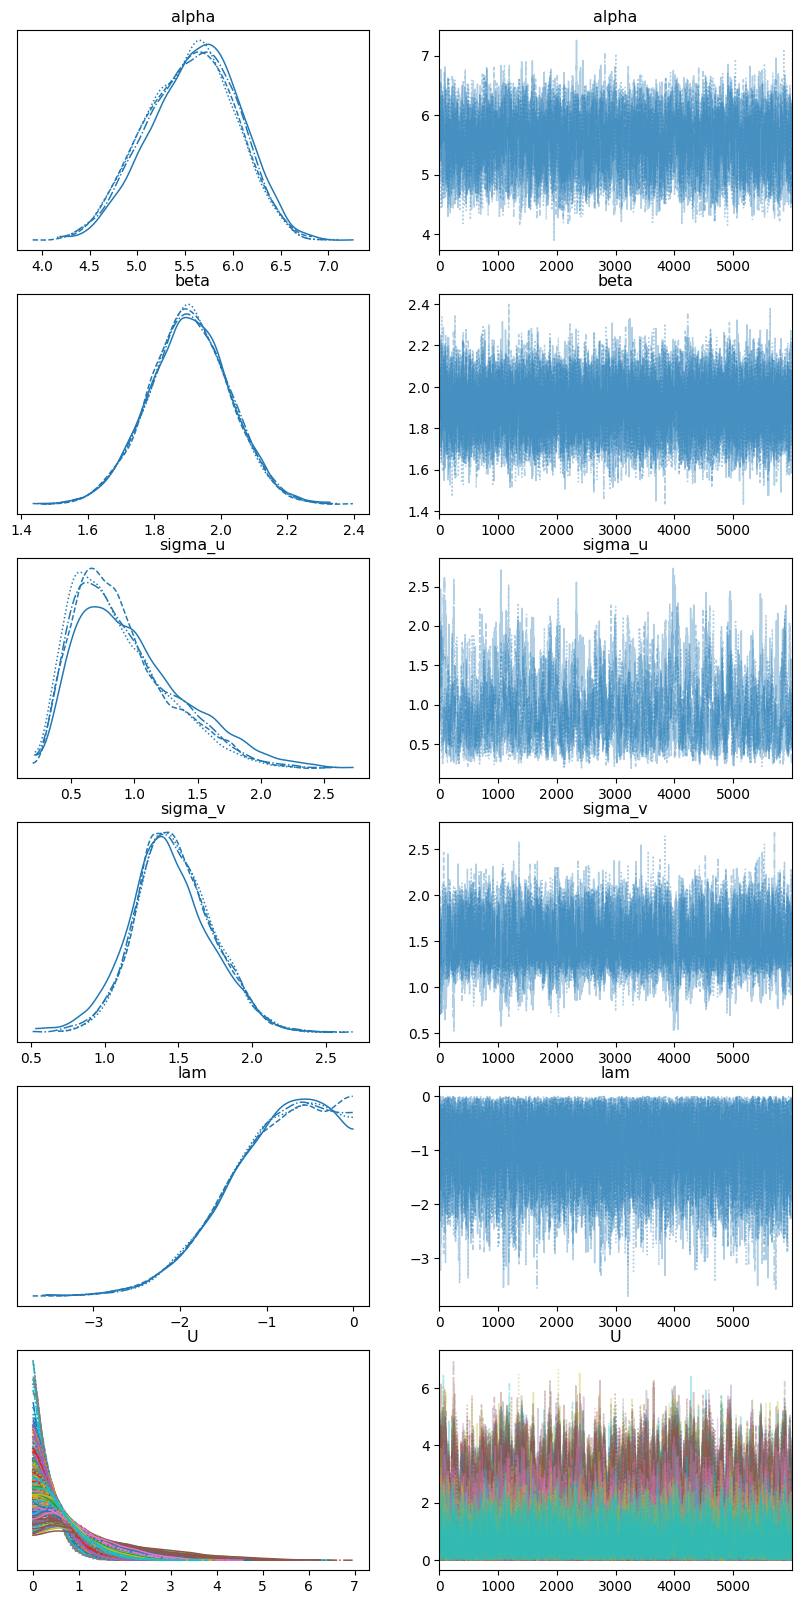

In [71]:
az.plot_trace(trace_skew[1][1], figsize=(10, 20));  # Use the second element (inference data)